# Model EVH - random design generation, WT vs 70.a mutation effect, G251W double mutations

In [1]:
#########################
#                       #
#                       #
#    LIBRARY IMPORT     #
#                       #
#                       #
#########################

import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import numba
import math
from evcouplings.couplings.model import _hamiltonians, _single_mutant_hamiltonians

In [2]:
#############################
#                           #
#                           #
#        CONSTANTS          #
#                           #
#                           #
#############################
LOCAL_DIR = '.'
DATA_DIR = LOCAL_DIR+'/data'
OUTPUT_DIR = LOCAL_DIR+'/figures/mutant_evh'
if not os.path.exists(OUTPUT_DIR): os.makedirs(OUTPUT_DIR)

In [3]:
#############################
#                           #
#                           #
#        LOAD DATA          #
#                           #
#                           #
#############################
from importlib import reload
sys.path.append(LOCAL_DIR) #Helper Functions Here
import FramHelperScripts
reload(FramHelperScripts)
FHS = FramHelperScripts.FramHelperFunctions(DATA_DIR)

In [4]:
model = FHS.get_model()
sequences = FHS.get_sequences_df().to_dict('records')
sequences_index = {rec['manuscript_name']: i for i, rec in enumerate(sequences)}
sequences_mapped = np.array([[model.alphabet_map[a] for a in rec['aligned_sequence']] for rec in sequences])
sequences_evh = _hamiltonians(sequences_mapped, model.J_ij, model.h_i)[:, 0]


In [5]:
list(sequences[0].keys())

['manuscript_name',
 'is_design',
 'EVH',
 'functional',
 'full_sequence',
 'aligned_sequence',
 'closest_natural_sequence',
 'natural_align_length',
 'identities_to_natural',
 'mut_to_natural',
 'percent_id_to_natural',
 'model_mutations']

# EVH of random controls of the same mutational depths

In [6]:
@numba.jit(nopython=True, nogil=True)
def _control_mut_pos(num_controls_per_design, num_mutations, L):
    control_mut_pos = np.empty((num_controls_per_design, num_mutations), dtype=np.int_)
    for i in range(num_controls_per_design):
        control_mut_pos[i] = np.random.choice(L, num_mutations, replace=False)
    return control_mut_pos

In [7]:
def generate_random_seqs(num_controls_per_design = 1000000):
    wt_sequences_mapped = np.tile(model.target_seq_mapped, (num_controls_per_design, 1))
    control_sequences_evh = np.empty((len(sequences), num_controls_per_design))
    for i, rec in enumerate(sequences):
        num_mutations = len(rec['model_mutations'])
        control_mut_pos = _control_mut_pos(num_controls_per_design, num_mutations, model.L)
        control_mut_symbol_shift = 1 + np.random.choice(model.num_symbols - 1, (num_controls_per_design, num_mutations), replace=True)
        control_sequences_mapped = wt_sequences_mapped.copy()
        control_sequences_mapped[np.arange(num_controls_per_design)[:, np.newaxis], control_mut_pos] += control_mut_symbol_shift
        control_sequences_mapped %= model.num_symbols
        control_sequences_evh[i] = _hamiltonians(control_sequences_mapped, model.J_ij, model.h_i)[:, 0]
    return control_sequences_evh

#1 million generated for figure, but this is too large for source data
control_sequences_evh = generate_random_seqs(num_controls_per_design = 10000)

Text(0.5, 0, 'EVH')

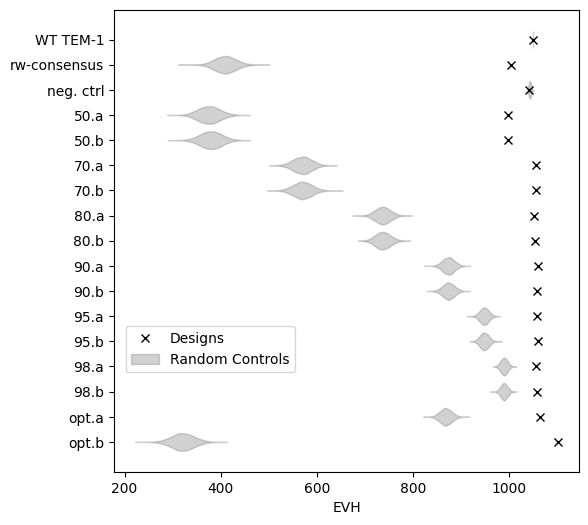

In [8]:
fig, ax = plt.subplots(figsize=(6 , 6))
ax.invert_yaxis()
ax.plot(sequences_evh, np.arange(len(sequences_evh)), 'x', color='#000000', label='Designs')
violin = ax.violinplot(control_sequences_evh.tolist(), positions=np.arange(0, len(sequences)), widths=0.7, vert=False, showextrema=False)
for p in violin['bodies']:
    p.set_color('dimgray')
violin['bodies'][0].set_label('Random Controls')
ax.legend(loc='lower left', frameon=True, bbox_to_anchor=(0.01, 0.2), bbox_transform=ax.transAxes)
ax.set_yticks(np.arange(len(sequences_evh)), [rec['manuscript_name'] for rec in sequences])
ax.set_xlabel('EVH')
# fig.savefig(os.path.join(OUTPUT_DIR, 'control_EVH_violin.pdf'), bbox_inches='tight')

In [9]:
#output small subset for 
pd.DataFrame(generate_random_seqs(
    num_controls_per_design=10000
).transpose()).set_axis(
    [rec['manuscript_name'] for rec in sequences],
    axis='columns'
).to_csv(OUTPUT_DIR+'/random_10k.tab', sep ='\t', index=False)

# WT vs 70.a single mutations ΔEVH

In [10]:
all_single_mut_devh = np.empty((len(sequences), model.L * (model.num_symbols - 1)))
for i in range(len(sequences)):
    tmp = _single_mutant_hamiltonians(sequences_mapped[i], model.J_ij, model.h_i)[:, :, 0].ravel()
    mask = np.full((model.L, model.num_symbols), True)
    mask[np.arange(model.L), sequences_mapped[i]] = False
    mask = mask.ravel()
    all_single_mut_devh[i] = tmp[mask]

single_mut_devh_wt_bg = all_single_mut_devh[sequences_index['WT TEM-1']]
single_mut_devh_70a_bg = all_single_mut_devh[sequences_index['70.a']]

seq_70a_mapped = sequences_mapped[sequences_index['70.a']]
mut_index_wt_to_70a = np.empty(len(sequences[sequences_index['70.a']]['model_mutations']), dtype=int)
mut_index_70a_to_wt = np.empty_like(mut_index_wt_to_70a)
j = 0
for i in range(model.L):
    if model.target_seq_mapped[i] < seq_70a_mapped[i]:
        mut_index_wt_to_70a[j] = i * (model.num_symbols - 1) + seq_70a_mapped[i] - 1
        mut_index_70a_to_wt[j] = i * (model.num_symbols - 1) + model.target_seq_mapped[i]
        j += 1
    elif model.target_seq_mapped[i] > seq_70a_mapped[i]:
        mut_index_wt_to_70a[j] = i * (model.num_symbols - 1) + seq_70a_mapped[i]
        mut_index_70a_to_wt[j] = i * (model.num_symbols - 1) + model.target_seq_mapped[i] - 1
        j += 1

In [11]:
def bin_edges(arr, binwidth):
    m1 = arr.min()
    m2 = arr.max()
    nbins = math.ceil((m2 - m1) / binwidth) // 2 * 2 + 1
    return np.linspace((m1 + m2 - nbins * binwidth)/2, (m1 + m2 + nbins * binwidth)/2, nbins + 1)

Text(0, 0.5, 'Frequency')

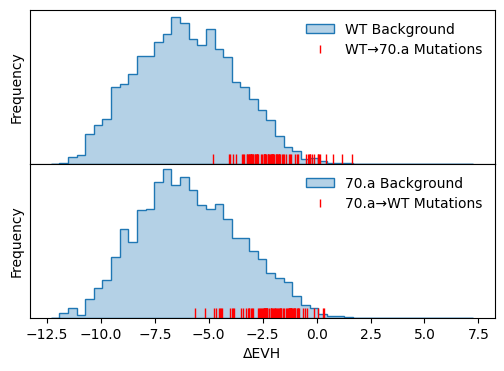

In [12]:
binwidth = 0.4
edges = bin_edges(all_single_mut_devh, binwidth)

fig, ax = plt.subplots(2, 1, figsize=(6, 4), gridspec_kw={'hspace': 0.})
ax[0].hist(single_mut_devh_wt_bg, bins=edges, histtype='stepfilled', edgecolor='#1f77b4', facecolor='#1f77b455', label='WT Background')
ax[0].vlines(single_mut_devh_wt_bg[mut_index_wt_to_70a], ymin=0, ymax=0.06, colors='red', linewidth=1, clip_on=False, transform=mpl.transforms.blended_transform_factory(ax[0].transData, ax[0].transAxes))
ax[0].plot([], [], '|', color='red', label='WT→70.a Mutations')
ax[0].legend(loc='upper right', frameon=False)
ax[0].tick_params(axis='y', left=False, labelleft=False)
ax[0].tick_params(axis='x', bottom=False, labelbottom=False)
ax[0].set_xlabel('ΔEVH')
ax[0].set_ylabel('Frequency')
ax[0].set_ylim(0, ax[0].get_ylim()[1])

ax[1].set_ylim(*ax[0].get_ylim())
ax[1].hist(single_mut_devh_70a_bg, bins=edges, histtype='stepfilled', edgecolor='#1f77b4', facecolor='#1f77b455', label='70.a Background')
ax[1].vlines(single_mut_devh_70a_bg[mut_index_70a_to_wt], ymin=0, ymax=0.06, colors='red', linewidth=1, clip_on=False, transform=mpl.transforms.blended_transform_factory(ax[1].transData, ax[1].transAxes))
ax[1].plot([], [], '|', color='red', label='70.a→WT Mutations')
ax[1].legend(loc='upper right', frameon=False)
ax[1].tick_params(axis='y', left=False, labelleft=False)
ax[1].set_xlabel('ΔEVH')
ax[1].set_ylabel('Frequency')
# fig.savefig(os.path.join(OUTPUT_DIR, 'WT_vs_70.a_mutations.pdf'), bbox_inches='tight')


# 70.a double mutations ΔEVH

In [13]:
mask = np.full_like(model.double_mut_mat, False, dtype=bool)
mask[model.index_map[248], :, model.alphabet_map['W'], :] = True
mask[:, model.index_map[248], :, model.alphabet_map['W']] = True
mask[model.index_map[248], model.index_map[248], :, :] = False
mask[np.arange(model.L), :, model.target_seq_mapped, :] = False
mask[:, np.arange(model.L), :, model.target_seq_mapped] = False
G248W_containing_double_mut_devh = model.double_mut_mat.ravel()[mask.ravel()]


In [14]:
mask = np.full_like(model.double_mut_mat, False, dtype=bool)
mask[model.index_map[248], np.arange(model.L), model.alphabet_map['W'], sequences_mapped[sequences_index['70.a']]] = True
mask[model.index_map[248], np.arange(model.L), model.alphabet_map['W'], model.target_seq_mapped] = False
mask[model.index_map[248], model.index_map[248], model.alphabet_map['W'], model.alphabet_map['W']] = False
G248W_70a_double_mut_devh = model.double_mut_mat.ravel()[mask.ravel()]


In [15]:
mask = np.full_like(model.double_mut_mat, True, dtype=bool)
mask[np.arange(model.L), np.arange(model.L), :, :] = False
mask[np.arange(model.L), :, model.target_seq_mapped, :] = False
mask[:, np.arange(model.L), :, model.target_seq_mapped] = False
all_double_mut_devh = model.double_mut_mat.ravel()[mask.ravel()]

Text(0, 0.5, 'Density')

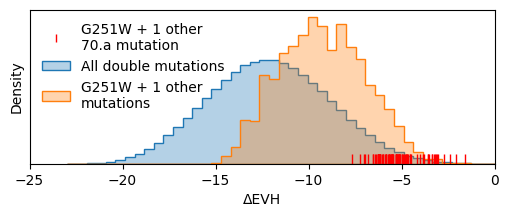

In [16]:
fig, ax = plt.subplots(figsize=(6, 2))
ax.plot([], [], '|', color='red', label='G251W + 1 other\n70.a mutation')
_, bins, _ = ax.hist(all_double_mut_devh, bins=50, density=True, histtype='stepfilled', edgecolor='#1f77b4', facecolor='#1f77b455', label='All double mutations')
ax.hist(G248W_containing_double_mut_devh, bins=bins, density=True, histtype='stepfilled', edgecolor='#ff7f0e', facecolor='#ff7f0e55', label='G251W + 1 other\nmutations')
ax.vlines(G248W_70a_double_mut_devh, ymin=0, ymax=0.06, colors='red', linewidth=1, clip_on=False, transform=mpl.transforms.blended_transform_factory(ax.transData, ax.transAxes))
ax.legend(loc='upper left', frameon=False)
ax.tick_params(axis='y', left=False, labelleft=False)
ax.set_xlim(-25, 0)
ax.set_xlabel('ΔEVH')
ax.set_ylabel('Density')
# fig.savefig(os.path.join(OUTPUT_DIR, '70.a_G251W_double_mutants_ΔEVH.pdf'), bbox_inches='tight')